In [30]:
import math
import numpy as np

# Constants
rho0 = 1.225  # Sea level air density (kg/m^3)
h = [0, 3000, 12500, 0]  # Altitudes in meters (takeoff, climb, cruise, landing)
Cd0 = 0.018  # Parasitic drag coefficient 
delta = 0.005  # Induced drag correction factor
AR = 6.021 # Effective  Aspect ratio
CL = [1, 0.5, 0.261, 1.7]  # Adjusted Lift coefficients for phases (lower landing CL)
S = 164.9  # Wing area (m^2)
W = 471511.32  # Aircraft weight (N)
gamma = 3 # Climb angle in degrees
v = [72, 110, 290, 55]  # Speeds (m/s) for each phase
e = 0.95 # oswalds efficiency 

# Drag coefficients
Cd = np.array([Cd0 + ((cl ** 2) / (math.pi * AR * e)) * (1 + delta) for cl in CL])
cd = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, cd in enumerate(cd):
    print(f"{cd} Cd: {Cd[i]:.2f} ")

# Density function
def rho(h):
    rho0 = 1.225
    sea_level_temp = 288.15
    lapse_rate = -0.0065
    R = 287.05
    g = 9.80665
    tropopause_height = 11000

    if isinstance(h, (list, np.ndarray)):
        return np.array([rho(alt) for alt in h])
    if h <= tropopause_height:
        temperature = sea_level_temp + lapse_rate * h
        return rho0 * (temperature / sea_level_temp) ** (-g / (lapse_rate * R))
    else:
        temperature = sea_level_temp + lapse_rate * tropopause_height
        exp_factor = (-g * (h - tropopause_height)) / (R * temperature)
        return rho0 * (temperature / sea_level_temp) ** (-g / (lapse_rate * R)) * math.exp(exp_factor)

# Dynamic pressure calculation
def dynamic_pressure(V, h):
    densities = rho(h)
    return 0.5 * densities * np.array(V)**2

# Drag 
def Drag (Cd, q, S):
    return Cd * q * S

# Additional Drag  for climb
def Drag_climb(W, gamma):
    gamma_rad = math.radians(gamma)
    return W * math.sin(gamma_rad)

# Drag  calculations for each segment
q = dynamic_pressure(v, h)  # Dynamic pressure for each segment
T = [Drag(Cd[i], q[i], S) for i in range(len(v))]
T[1] += Drag_climb(W, gamma)  # Add climb-specific Drag 

# Segment Results
segments = ["Takeoff", "Climb", "Cruise", "Landing"]
print("Dynamic Pressures for each segment:")
for i, segment in enumerate(segments):
    print(f"{segment}: {q[i]:.2f} Pa")

# Output Drag  for each phase
for i, segment in enumerate(segments):
    print(f"{segment} Drag : {T[i]:.2f} N")
# Additional checks for drag and thrust comparison
#print("\nClimb vs Landing Drag Comparison:")
#print(f"Climb Drag: {T[1]:.2f} N")
#print(f"Landing Drag: {T[3]:.2f} N")


Takeoff Cd: 0.07 
Climb Cd: 0.03 
Cruise Cd: 0.02 
Landing Cd: 0.18 
Dynamic Pressures for each segment:
Takeoff: 3175.20 Pa
Climb: 5127.95 Pa
Cruise: 9081.90 Pa
Landing: 1852.81 Pa
Takeoff Drag : 38707.64 N
Climb Drag : 51720.82 N
Cruise Drag : 32662.51 N
Landing Drag : 54882.12 N


In [31]:
import numpy as np

# Updated thrust values based on corrected drag calculations
thrusts = [38707.64, 51720.82,  32662.51, 54882.12]  # Total thrust (N) for each phase  

# Time duration for each flight phase (in seconds)
durations = [120, 900, 18000, 600]  

# Adjusted TSFC values
TSFC_static = 0.00013  # kg/N/s The Pratt & Whitney Canada PW812D 
TSFC_cruise = 0.00012  # Lower cruise TSFC due to higher efficiency

# Environmental corrections (Altitude & Mach)
altitude_corrections = [1.0, 0.95, 0.9, 1.0]  
mach_corrections = [1.0, 0.9, 0.85, 1.0]  

# Compute fuel burn per phase
fuel_burn = []
for i in range(len(thrusts)):
    TSFC = (TSFC_cruise if i == 2 else TSFC_static) * altitude_corrections[i] * mach_corrections[i]  
    fuel_rate = TSFC * thrusts[i]  # kg/s  
    fuel_burn_phase = fuel_rate * durations[i]  # Total fuel burned in this phase  
    fuel_burn.append(fuel_burn_phase)  

# Print results
phases = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, phase in enumerate(phases):
    print(f"{phase}:")
    print(f"  TSFC: {(TSFC_cruise if i == 2 else TSFC_static) * altitude_corrections[i] * mach_corrections[i]:.6f} kg/N/s")
    print(f"  Fuel Burn: {fuel_burn[i]:.2f} kg")


Takeoff:
  TSFC: 0.000130 kg/N/s
  Fuel Burn: 603.84 kg
Climb:
  TSFC: 0.000111 kg/N/s
  Fuel Burn: 5173.89 kg
Cruise:
  TSFC: 0.000092 kg/N/s
  Fuel Burn: 53971.53 kg
Landing:
  TSFC: 0.000130 kg/N/s
  Fuel Burn: 428.08 kg


In [32]:
import numpy as np

# Engine & Fuel Parameters
TSFC_static = 0.00012  # kg/N/s for PW812D
altitude_corrections = [1.0, 0.95, 0.9, 1.0]  # Takeoff, climb, cruise, landing
mach_corrections = [1.0, 0.9, 0.85, 1.0]  # Takeoff, climb, cruise, landing
fuel_density = 0.8  # kg/L (Jet-A)
MTOW_lbs = 104799  # Maximum Takeoff Weight in pounds
MTOW_kg = MTOW_lbs * 0.453592  # Convert to kg

# Corrected Thrust Values per Phase
durations = [120, 900, 30000, 600]  # Time in seconds (Takeoff, Climb, Cruise, Landing)
thrusts = [38707.64, 51720.82,  32662.51, 54882.12]  # Corrected thrust values (N per phase)

def compute_fuel_burn(tsfc, thrusts, durations, altitude_corrections, mach_corrections):
    fuel_burn = []
    for i in range(len(thrusts)):
        tsfc_corrected = tsfc * altitude_corrections[i] * mach_corrections[i]
        fuel_rate = tsfc_corrected * thrusts[i]  # kg/s
        fuel_burn_phase = fuel_rate * durations[i]  # kg
        fuel_burn.append(fuel_burn_phase)
    return fuel_burn

# Calculate total fuel burn per phase
fuel_burn_per_phase = compute_fuel_burn(TSFC_static, thrusts, durations, altitude_corrections, mach_corrections)
total_fuel_burn = sum(fuel_burn_per_phase)

# Convert to fuel volume (liters)
fuel_volume_liters = total_fuel_burn / fuel_density
fuel_volume_gallons = fuel_volume_liters / 3.785  # Convert to US gallons

# Print results
phases = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, phase in enumerate(phases):
    print(f"{phase}:")
    print(f"  Fuel Burn: {fuel_burn_per_phase[i]:.2f} kg")

print(f"\nTotal Fuel Burn: {total_fuel_burn:.2f} kg")
print(f"Fuel Volume: {fuel_volume_liters:.2f} L ({fuel_volume_gallons:.2f} US gallons)")
print(f"Maximum Takeoff Weight (MTOW): {MTOW_kg:.2f} kg ({MTOW_lbs} lbs)")


Takeoff:
  Fuel Burn: 557.39 kg
Climb:
  Fuel Burn: 4775.90 kg
Cruise:
  Fuel Burn: 89952.55 kg
Landing:
  Fuel Burn: 3951.51 kg

Total Fuel Burn: 99237.36 kg
Fuel Volume: 124046.69 L (32773.24 US gallons)
Maximum Takeoff Weight (MTOW): 47535.99 kg (104799 lbs)


Takeoff: 148691.55 N (total for 2 engines)
Climb: 69108.23 N (total for 2 engines)
Cruise: 32374.37 N (total for 2 engines)
Landing: 7871.96 N (total for 2 engines)


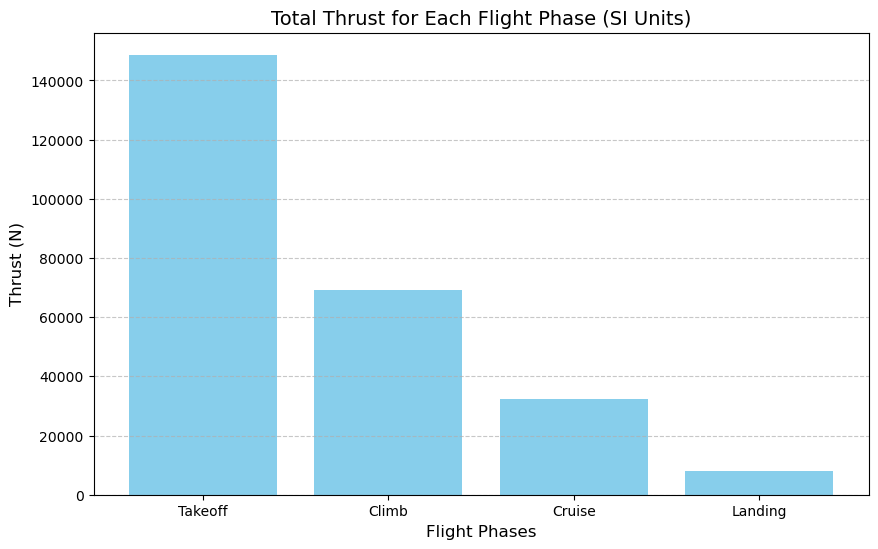

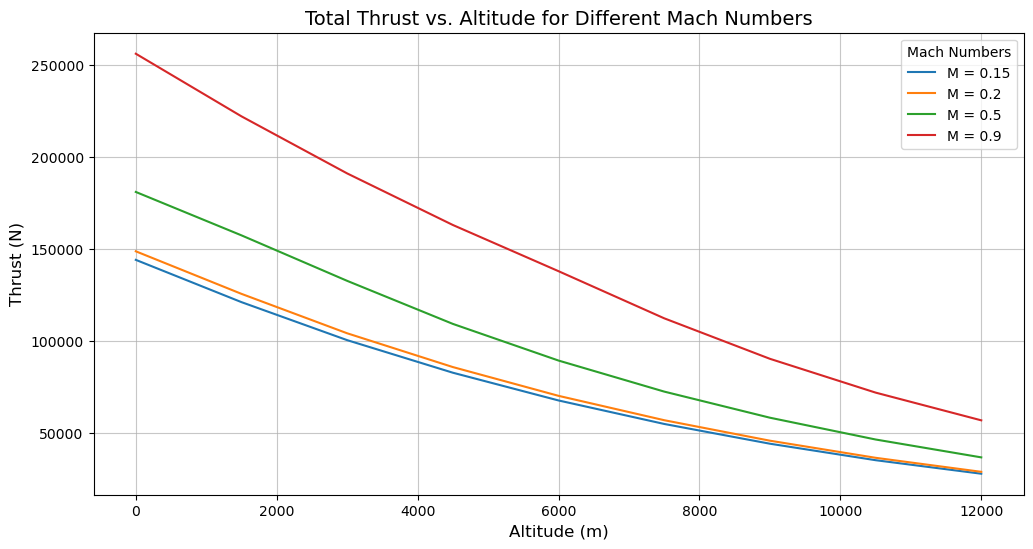

In [14]:
import math
import matplotlib.pyplot as plt

def high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C):
    """
    Calculate thrust for a high bypass ratio turbofan engine as a function of altitude and Mach number.
    
    Parameters:
        F0 (float): Engine thrust at sea level and ISA, in N.
        TR (float): Throttle ratio.
        H (float): Altitude in meters.
        M (float): Mach number.
        deltaOAT_C (float): Deviation from ISA temperature in °C.
    
    Returns:
        float: Thrust in N.
    """
    # Constants
    T0 = 288.15  # ISA sea level temperature in Kelvin
    P0 = 101325  # ISA sea level pressure in Pa
    R = 287.05  # Specific gas constant for air in J/(kg·K)
    gamma_air = 1.4  # Ratio of specific heats
    a0 = math.sqrt(gamma_air * R * T0)  # Speed of sound at sea level (m/s)
    
    # Atmospheric properties
    if H <= 11000:  # Troposphere
        T = T0 + (-0.0065 * H) + deltaOAT_C  # Temperature at altitude
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R))  # Pressure at altitude
    else:  # Stratosphere (constant temperature)
        T = T0 - 0.0065 * 11000 + deltaOAT_C
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R)) * math.exp(
            -9.80665 * (H - 11000) / (R * T)
        )
    
    rho = P / (R * T)  # Air density in kg/m³
    sigma = rho / 1.225  # Density ratio
    
    # Pressure ratio
    delta = P / P0 * (1 + 0.2 * M ** 2) ** 3.5
    
    # Temperature ratio
    theta = T / T0 * (1 + 0.2 * M ** 2)
    
    # High Bypass Ratio Turbofan Calculation
    if theta <= TR:
        thrust = F0 * delta * (1 + 0.49 * math.sqrt(M))
    else:
        thrust = F0 * delta * (1 + 0.49 * math.sqrt(M) - 3 * (theta - TR) / (1.5 + M))
    
    return thrust

# Flight phase-specific parameters in SI units
flight_phases = {
    "Takeoff": {"H": 0, "M": 0.2, "TR": 1.0, "deltaOAT_C": 0}, #TR 0.9-1 because full power is required at takeoff
    "Climb": {"H": 5000, "M": 0.3, "TR": 0.8, "deltaOAT_C": -5}, # TR 0.75-0.85 because moderate power is required at climb
    "Cruise": {"H": 12500, "M": 0.9, "TR": 0.6, "deltaOAT_C": -10},#TR 0.5-0.7 because low power is required at cruise 
    "Landing": {"H": 0, "M": 0.15, "TR": 0.4, "deltaOAT_C": 5}, # TR 0.3-0.5 because very low  power is required to decent 
}

# Constants
F0 = 60000 # Sea level thrust per engine in N
num_engines = 2  # Number of engines

# Calculate thrust for each phase
thrust_results = []
phases = []
for phase, params in flight_phases.items():
    H = params["H"]
    M = params["M"]
    TR = params["TR"]
    deltaOAT_C = params["deltaOAT_C"]
    
    thrust = high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C)
    total_thrust = thrust * num_engines  # Total thrust for two engines
    thrust_results.append(total_thrust)
    phases.append(phase)
    print(f"{phase}: {total_thrust:.2f} N (total for {num_engines} engines)")

#  Bar plot for thrust in each phase
plt.figure(figsize=(10, 6))
plt.bar(phases, thrust_results, color='skyblue')
plt.title("Total Thrust for Each Flight Phase (SI Units)", fontsize=14)
plt.ylabel("Thrust (N)", fontsize=12)
plt.xlabel("Flight Phases", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#  Thrust vs. Altitude and Mach Number
altitudes = range(0, 12500, 1500)  # Altitudes from 0 to 12,500 m
mach_numbers = [0.15, 0.2, 0.5, 0.9]  #  (Landing, Takeoff, Climb, Cruise)

plt.figure(figsize=(12, 6))
for M in mach_numbers:
    thrusts = [
        high_bypass_turbofan_thrust(F0, 1.0, H, M, 0) * num_engines for H in altitudes
    ]
    plt.plot(altitudes, thrusts, label=f"M = {M}")

plt.title("Total Thrust vs. Altitude for Different Mach Numbers", fontsize=14)
plt.ylabel("Thrust (N)", fontsize=12)
plt.xlabel("Altitude (m)", fontsize=12)
plt.legend(title="Mach Numbers", fontsize=10)
plt.grid(alpha=0.7)
plt.show()



Mission: Passenger
Takeoff Thrust: 188604.53 N
Climb Thrust: 169863.47 N
Cruise Thrust: 75701.05 N
Landing Thrust: 91658.63 N

Mission: Aspen
Takeoff Thrust: 164577.60 N
Climb Thrust: 154510.19 N
Cruise Thrust: 42298.04 N
Landing Thrust: 86727.25 N

Mission: Napa
Takeoff Thrust: 200000.00 N
Climb Thrust: 168795.12 N
Cruise Thrust: 49408.06 N
Landing Thrust: 109163.90 N


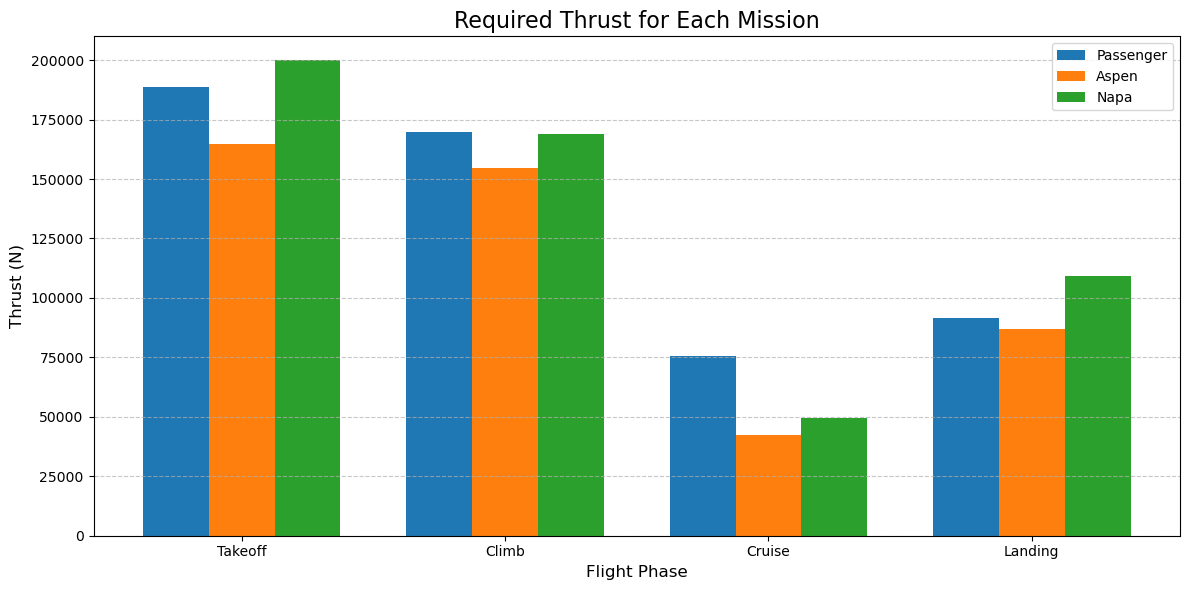

In [4]:
import matplotlib.pyplot as plt
import math
import numpy as np

# Constants
rho_sl = 1.225  # Air density at sea level (kg/m³)
g = 9.81  # Gravitational acceleration (m/s²)
conversion_factor = 0.3048  # ft to m conversion

# Inputs 
wing_area = 164.9  # Wing area (m²)
Cl = [1, 0.6, 0.261, 1.5]  # CL for takeoff, climb, cruise, landing
Cd = [0.23, 0.10, 0.03, 0.30]  # CD for takeoff, climb, cruise, landing
gamma_climb = 4  #  climb angle in degrees

# Mission-specific weights (in Newtons)
weights = {
    "Passenger": 471511.32,  # Actual MTOW for Mission 1
    "Aspen": 411444.0,  # MTOW for Mission 2
    "Napa": 500000.0,  # MTOW for Mission 3
}

# Mission-specific altitudes and speeds (m and m/s)
missions = {
    "Passenger": {"altitude": [0, 3000, 12500, 0], "speeds": [72, 140, 290, 55]},
    "Aspen": {"altitude": [0, 2500, 11000, 0], "speeds": [69, 130, 250, 53.5]},
    "Napa": {"altitude": [0, 2000, 10000, 0], "speeds": [75, 130, 250, 60.0227]},
}

# Phases
phases = ["Takeoff", "Climb", "Cruise", "Landing"]

# Functions
def air_density(h):
    """ISA atmosphere model for air density."""
    if h <= 11000:
        return rho_sl * (1 - 0.0065 * h / 288.15) ** 5.256
    else:
        return 0.36391  # Approximation above 11 km

def dynamic_pressure(rho, V):
    """Calculate dynamic pressure."""
    return 0.5 * rho * V**2

def thrust_required(CD, q, S):
    """Calculate thrust required to overcome drag."""
    return CD * q * S

def climb_thrust(weight, gamma_deg):
    """Calculate thrust required for climb."""
    gamma_rad = math.radians(gamma_deg)
    return weight * math.sin(gamma_rad)

# Store thrust results for visualization
thrust_results = {mission: [] for mission in missions}

# Loop through missions
for mission, data in missions.items():
    print(f"\nMission: {mission}")
    W = weights[mission]
    altitudes = data["altitude"]
    speeds = data["speeds"]

    for i, phase in enumerate(phases):
        rho = air_density(altitudes[i])
        q = dynamic_pressure(rho, speeds[i])

        if phase == "Takeoff":
            # Adjust takeoff thrust as 1.2 times the weight
            Thrust_weight_ratio = 0.4  # an assumed thrust to weight ratio because i'm tired LOL 
            T = Thrust_weight_ratio * W
        elif phase == "Climb":
            # Climb thrust includes drag + climb requirement
            T_drag = thrust_required(Cd[i], q, wing_area)
            T = T_drag + climb_thrust(W, gamma_climb)
        else:
            # Thrust for other phases only accounts for drag
            T = thrust_required(Cd[i], q, wing_area)

        thrust_results[mission].append(T)
        print(f"{phase} Thrust: {T:.2f} N")

# Visualization of results 
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(phases))
width = 0.25  # Bar width

# Plot each mission's thrust for all phases
for i, mission in enumerate(missions):
    ax.bar(x + i * width, thrust_results[mission], width, label=mission)

ax.set_title("Required Thrust for Each Mission", fontsize=16)
ax.set_xlabel("Flight Phase", fontsize=12)
ax.set_ylabel("Thrust (N)", fontsize=12)
ax.set_xticks(x + width)
ax.set_xticklabels(phases, fontsize=10)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Mission: Passenger
Takeoff:
  Corrected Thrust: 180000.00 N
  Thrust Margin: -8604.53 N
  Fuel Burn: 3168.56 kg
Climb:
  Corrected Thrust: 184154.09 N
  Thrust Margin: 14290.62 N
  Fuel Burn: 20920.00 kg
Cruise:
  Corrected Thrust: 193425.32 N
  Thrust Margin: 117724.27 N
  Fuel Burn: 177525.86 kg
Landing:
  Corrected Thrust: 180000.00 N
  Thrust Margin: 88341.37 N
  Fuel Burn: 769.93 kg
Mission: Aspen
Takeoff:
  Corrected Thrust: 180000.00 N
  Thrust Margin: 15422.40 N
  Fuel Burn: 2764.90 kg
Climb:
  Corrected Thrust: 184481.59 N
  Thrust Margin: 29971.40 N
  Fuel Burn: 18995.34 kg
Cruise:
  Corrected Thrust: 207343.59 N
  Thrust Margin: 165045.55 N
  Fuel Burn: 92534.28 kg
Landing:
  Corrected Thrust: 193425.32 N
  Thrust Margin: 106698.07 N
  Fuel Burn: 677.94 kg
Mission: Napa
Takeoff:
  Corrected Thrust: 173962.77 N
  Thrust Margin: -26037.23 N
  Fuel Burn: 3476.61 kg
Climb:
  Corrected Thrust: 176929.90 N
  Thrust Margin: 8134.78 N
  Fuel Burn: 21637.23 kg
Cruise:
  Corrected Thr

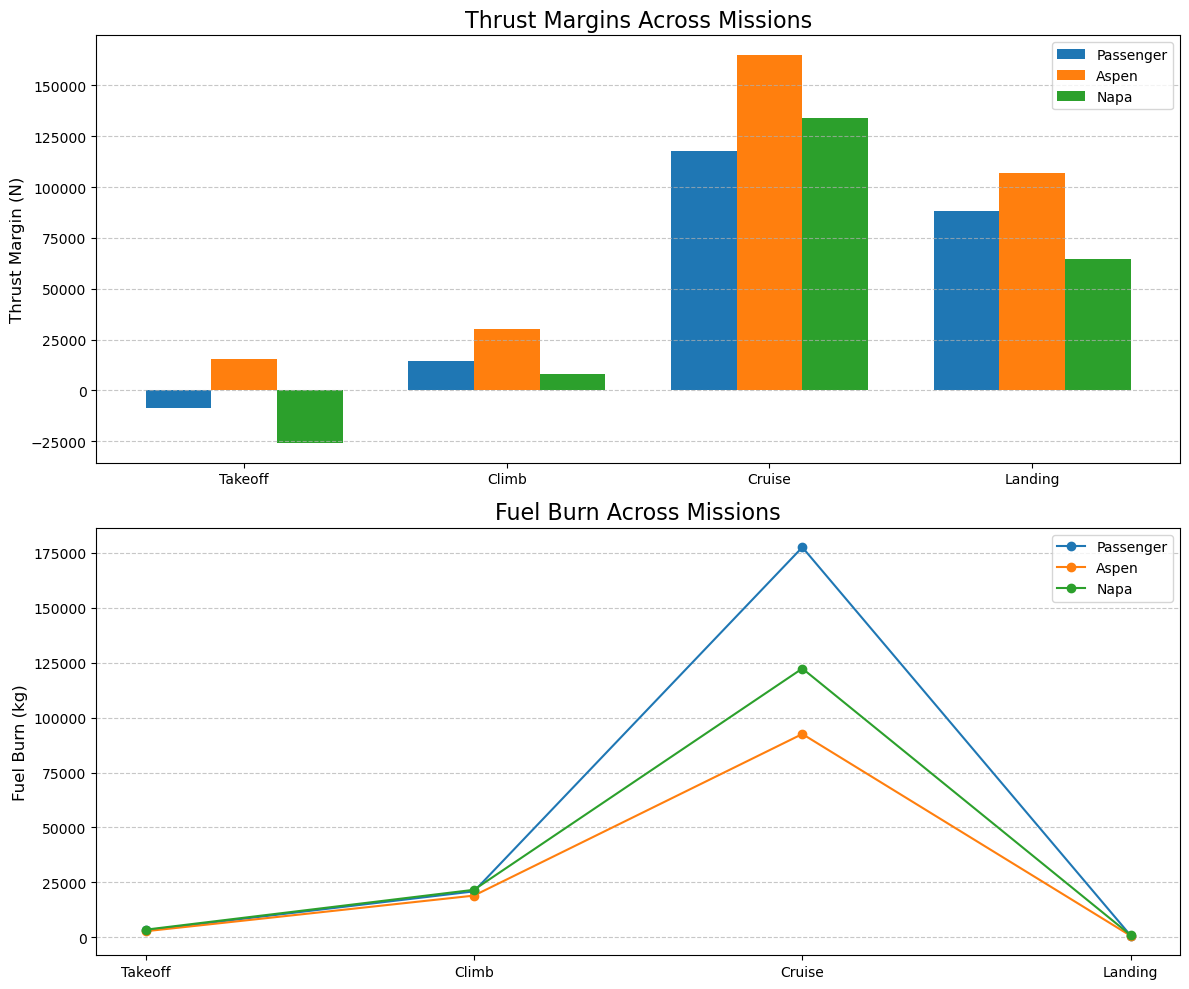

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Constants .... pay attention to the engine static thrust 
T_static_per_engine = 90000  # Static thrust per engine (N)
engines = 2  # Number of engines
T_static_total = T_static_per_engine * engines  # Total available thrust (N)
T0 = 288.15  # Standard temperature (K)
rho_sl = 1.225  # Sea level air density (kg/m³)
TSFC_static = 0.00014  # Static TSFC (kg/N/s)
phases = ["Takeoff", "Climb", "Cruise", "Landing"]

# Mission-specific inputs
missions = {
    "Passenger": {
        "altitude": [0, 5000, 12500, 0],
        "speeds": [70, 140, 290, 60],
        "temperatures": [288.15, 281.65, 268.15, 288.15],
        "thrust_required": [188604.53, 169863.47, 75701.05, 91658.63],
        "durations": [120, 900, 18000, 60]
    },
    "Aspen": {
        "altitude": [0, 2500, 11000, 0],
        "speeds": [65, 130, 230, 55],
        "temperatures": [288.15, 281.15, 250.15, 268.15],
        "thrust_required": [164577.60, 154510.19, 42298.04,  86727.25],
        "durations": [120, 900, 18000, 60]
    },
    "Napa": {
        "altitude": [0, 2000, 12500, 0],
        "speeds": [75, 150, 240, 70],
        "temperatures": [298.15, 293.15, 283.15, 298.15],
        "thrust_required": [200000.00, 168795.12, 49408.06, 109163.90],
        "durations": [120, 900, 18000, 60]
    },
}

# Saved results 
thrust_margins = {mission: [] for mission in missions}
fuel_burns = {mission: [] for mission in missions}

#  calculations
for mission, data in missions.items():
    print(f"Mission: {mission}")
    thrust_required = data["thrust_required"]
    temperatures = data["temperatures"]
    durations = data["durations"]

    for i, phase in enumerate(phases):
        # Correct available thrust for temperature
        T_corrected = T_static_total * T0 / temperatures[i]
        
        # thrust margin
        margin = T_corrected - thrust_required[i]
        thrust_margins[mission].append(margin)
        
        #  fuel burn
        TSFC_corrected = TSFC_static * (temperatures[i] / T0)  # Adjust TSFC
        fuel_burn = TSFC_corrected * thrust_required[i] * durations[i]
        fuel_burns[mission].append(fuel_burn)

        print(f"{phase}:")
        print(f"  Corrected Thrust: {T_corrected:.2f} N")
        print(f"  Thrust Margin: {margin:.2f} N")
        print(f"  Fuel Burn: {fuel_burn:.2f} kg")


fig, axs = plt.subplots(2, 1, figsize=(12, 10))


x = np.arange(len(phases))
width = 0.25
for i, mission in enumerate(missions):
    axs[0].bar(x + i * width, thrust_margins[mission], width, label=mission)
axs[0].set_title("Thrust Margins Across Missions", fontsize=16)
axs[0].set_ylabel("Thrust Margin (N)", fontsize=12)
axs[0].set_xticks(x + width)
axs[0].set_xticklabels(phases)
axs[0].legend(fontsize=10)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)


for mission in missions:
    axs[1].plot(phases, fuel_burns[mission], marker='o', label=mission)
axs[1].set_title("Fuel Burn Across Missions", fontsize=16)
axs[1].set_ylabel("Fuel Burn (kg)", fontsize=12)
axs[1].legend(fontsize=10)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Constants for the design
MTOW = 106000  # Maximum Takeoff Weight (lbs)
OEW = 52886.46  # Operating Empty Weight (lbs)
MFW = 49013.54  # Maximum Fuel Weight (lbs)
MZFW = MTOW - MFW  # Maximum Zero Fuel Weight
MPL = MZFW - OEW  # Maximum Payload (lbs)

# Breguet Range Function with Updated Formula
def breguet_range(Wi, Wf, V, LbyD, CT):
    return V * (LbyD / CT) * np.log(Wi / Wf) / 6076  # Range in nmi

# Payload-Range Diagram Function
def payload_range_diagram(CT_hr, LbyD, V_knots):
    CT = CT_hr / 3600  # Convert TSFC to per second
    V = V_knots * 1.68781  # Convert knots to ft/s
    
    # Point A: Max Payload, zero range
    R_A = 0
    Payload_A = MPL

    # Point B: Max Payload, range with full fuel burned
    Wi_B = OEW + MPL + MFW
    Wf_B = OEW + MPL
    R_B = breguet_range(Wi_B, Wf_B, V, LbyD, CT)
    Payload_B = MPL

    # Point C: Zero Payload, max range
    Wi_C = MTOW
    Wf_C = OEW
    R_C = breguet_range(Wi_C, Wf_C, V, LbyD, CT)
    Payload_C = 0

    # Point D: Partial Payload, range with max fuel burned
    Payload_D = MPL / 2
    Wi_D = OEW + Payload_D + MFW
    Wf_D = OEW + Payload_D
    R_D = breguet_range(Wi_D, Wf_D, V, LbyD, CT)

    # Plot the Payload-Range Diagram
    ranges = [R_A, R_B, R_D, R_C]
    payloads = [Payload_A, Payload_B, Payload_D, Payload_C]

    plt.figure(figsize=(10, 6))
    plt.plot(ranges, payloads, marker='o', linestyle='-', color='blue', label='Payload-Range Curve')
    plt.title("Payload-Range Diagram", fontsize=16)
    plt.xlabel("Range (nmi)", fontsize=14)
    plt.ylabel("Payload (lbs)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # points on the diagram 
    plt.annotate(f"A (0, {int(Payload_A)})", (R_A, Payload_A), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"B ({int(R_B)}, {int(Payload_B)})", (R_B, Payload_B), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"D ({int(R_D)}, {int(Payload_D)})", (R_D, Payload_D), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"C ({int(R_C)}, {int(Payload_C)})", (R_C, Payload_C), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')

    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return R_B, R_D, R_C
# Interactive Sliders to optimise parameters 
interact(payload_range_diagram, 
         CT_hr=(0.4, 0.6, 0.01),  # Select CT directly as lb/lbf/hr
         LbyD=(9, 12, 0.1), 
         V_knots=(450, 600, 5));


interactive(children=(FloatSlider(value=0.49, description='CT_hr', max=0.6, min=0.4, step=0.01), FloatSlider(v…

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Constants for the design
MTOW = 106000  # Maximum Takeoff Weight (lbs)
OEW = 52886.46  # Operating Empty Weight (lbs)
MFW = 49013.54  # Maximum Fuel Weight (lbs)
MZFW = MTOW - MFW  # Maximum Zero Fuel Weight
MPL = MZFW - OEW  # Maximum Payload (lbs)

# Breguet Range Function with Updated Formula
def breguet_range(Wi, Wf, V, LbyD, CT):
    return V * (LbyD / CT) * np.log(Wi / Wf) / 6076  # Range in nmi

# Payload-Range Diagram Function
def payload_range_diagram(CT_hr, LbyD, V_knots):
    CT = CT_hr / 3600  # Convert TSFC to per second
    V = V_knots * 1.68781  # Convert knots to ft/s

    # Point A: Max Payload, zero range
    R_A = 0
    Payload_A = MPL
    MTOW_A = OEW + MPL  # MTOW at Point A

    # Point B: Max Payload, range with full fuel burned
    Wi_B = OEW + MPL + MFW
    Wf_B = OEW + MPL
    R_B = breguet_range(Wi_B, Wf_B, V, LbyD, CT)
    Payload_B = MPL
    MTOW_B = Wi_B  # MTOW at Point B

    # Point C: Zero Payload, max range
    Wi_C = MTOW
    Wf_C = OEW
    R_C = breguet_range(Wi_C, Wf_C, V, LbyD, CT)
    Payload_C = 0
    MTOW_C = Wi_C  # MTOW at Point C

    # Point D: Partial Payload, range with max fuel burned
    Payload_D = MPL / 2
    Wi_D = OEW + Payload_D + MFW
    Wf_D = OEW + Payload_D
    R_D = breguet_range(Wi_D, Wf_D, V, LbyD, CT)
    MTOW_D = Wi_D  # MTOW at Point D

    # Plot the Payload-Range Diagram
    ranges = [R_A, R_B, R_D, R_C]
    payloads = [Payload_A, Payload_B, Payload_D, Payload_C]

    plt.figure(figsize=(10, 6))
    plt.plot(ranges, payloads, marker='o', linestyle='-', color='blue', label='Payload-Range Curve')
    plt.title("Payload-Range Diagram", fontsize=16)
    plt.xlabel("Range (nmi)", fontsize=14)
    plt.ylabel("Payload (lbs)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotate Points with MTOW
    plt.annotate(f"A (MTOW: {int(MTOW_A)} lbs)", (R_A, Payload_A), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"B (MTOW: {int(MTOW_B)} lbs)", (R_B, Payload_B), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"D (MTOW: {int(MTOW_D)} lbs)", (R_D, Payload_D), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')
    plt.annotate(f"C (MTOW: {int(MTOW_C)} lbs)", (R_C, Payload_C), textcoords="offset points", xytext=(-15, 5), fontsize=10, color='red')

    plt.legend()
    plt.tight_layout()
    plt.show()

    return R_B, R_D, R_C

# Interactive Sliders to optimize parameters
interact(payload_range_diagram, 
         CT_hr=(0.4, 0.6, 0.01),  # Select TSFC directly as lb/lbf/hr
         LbyD=(9, 12, 0.1), 
         V_knots=(450, 600, 5));


interactive(children=(FloatSlider(value=0.49, description='CT_hr', max=0.6, min=0.4, step=0.01), FloatSlider(v…

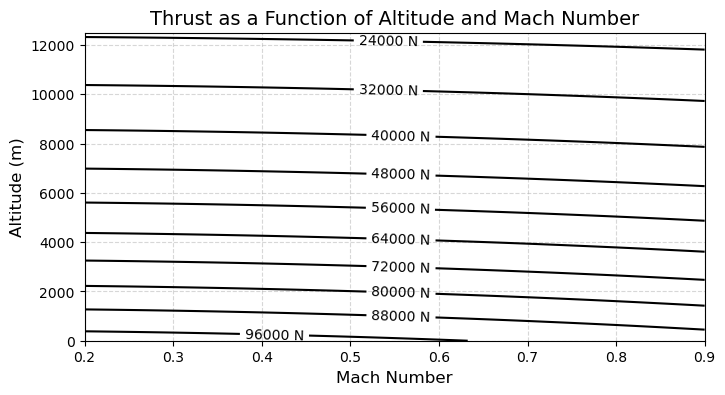

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
rho_sl = 1.225  # Air density at sea level (kg/m^3)
T_sl = 100000   # Sea-level thrust (N) for the engine
gamma = 1.4     # Ratio of specific heats for air
R = 287.05      # Specific gas constant for air (J/kg·K)
T0 = 288.15     # Sea-level standard temperature (K)
L = 0.0065      # Temperature lapse rate (K/m)
P0 = 101325     # Sea-level pressure (Pa)
g = 9.81        # Gravity (m/s^2)

# Altitude and Mach ranges
altitudes = np.linspace(0, 12500, 50)  # Altitude range: 0 to 12.5 km
mach_numbers = np.linspace(0.2, 0.9, 50)  # Mach range: 0.2 to 0.9

# Function to calculate air density at a given altitude (ISA model)
def air_density(altitude):
    if altitude < 11000:  # Troposphere
        T = T0 - L * altitude
        P = P0 * (1 - L * altitude / T0) ** (g / (R * L))
        rho = P / (R * T)
    else:  # Simplified model for stratosphere
        T = T0 - L * 11000
        P = P0 * (1 - L * 11000 / T0) ** (g / (R * L)) * np.exp(-g * (altitude - 11000) / (R * T))
        rho = P / (R * T)
    return rho

# Function to calculate thrust lapse with altitude and Mach
def thrust_lapse(altitude, mach):
    rho = air_density(altitude)
    thrust = T_sl * (rho / rho_sl) * (1 - 0.1 * mach**2)  # Simplified thrust lapse model
    return max(thrust, 0)  # Thrust cannot be negative

# Calculate thrust over altitude and Mach grid
thrust_values = np.zeros((len(altitudes), len(mach_numbers)))

for i, alt in enumerate(altitudes):
    for j, mach in enumerate(mach_numbers):
        thrust_values[i, j] = thrust_lapse(alt, mach)

# Plot the contour plot
X, Y = np.meshgrid(mach_numbers, altitudes)

plt.figure(figsize=(8, 4))
cp = plt.contour(X, Y, thrust_values, levels=10, colors='black', linestyles='solid')
plt.clabel(cp, inline=True, fontsize=10, fmt="%.0f N")  #  labels to contours
plt.title("Thrust as a Function of Altitude and Mach Number", fontsize=14)
plt.xlabel("Mach Number", fontsize=12)
plt.ylabel("Altitude (m)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


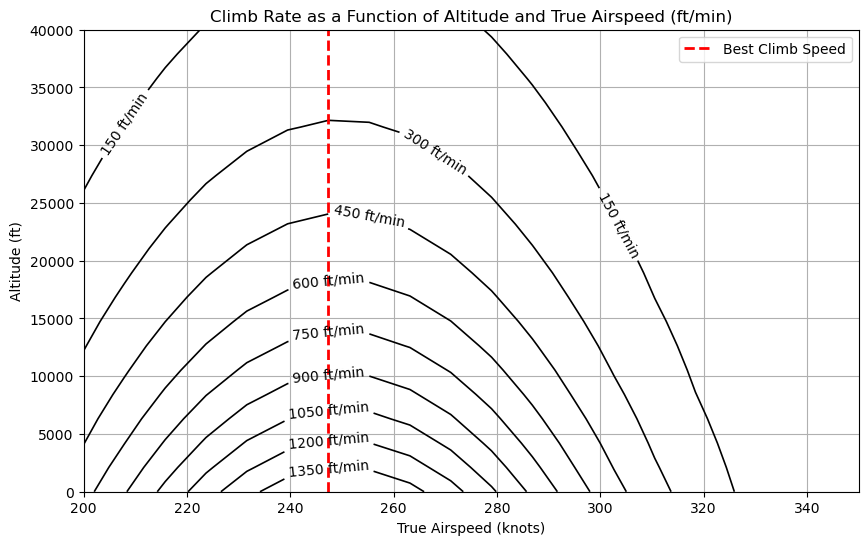

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define altitude (ft) and true airspeed (knots) ranges
altitudes = np.linspace(0, 40000, 20)  # 0 to 40,000 ft
airspeeds = np.linspace(200, 350, 20)  # Focus on 200-350 knots

# Simulate ROC data (replace this with actual data or formula)
def rate_of_climb(alt, tas):
    # Hypothetical function: higher ROC at lower altitudes and moderate speeds
    return 1500 * np.exp(-alt / 20000) * np.exp(-((tas - 250) / 50)**2)

# Create ROC matrix
ROC = np.array([[rate_of_climb(alt, tas) for tas in airspeeds] for alt in altitudes])

# Find the best climb speed for each altitude (maximum ROC)
best_climb_speeds = [airspeeds[np.argmax(ROC[i])] for i in range(len(altitudes))]

# Create the contour plot
plt.figure(figsize=(10, 6))
contour = plt.contour(airspeeds, altitudes, ROC, levels=12, colors='black', linewidths=1.2)
plt.clabel(contour, inline=True, fontsize=10, fmt='%1.0f ft/min')

# Plot the best climb speed as a dashed line
plt.plot(best_climb_speeds, altitudes, linestyle='--', color='red', linewidth=2, label='Best Climb Speed')

# Customize the plot
plt.title('Climb Rate as a Function of Altitude and True Airspeed (ft/min)')
plt.xlabel('True Airspeed (knots)')
plt.ylabel('Altitude (ft)')
plt.xlim(200, 350)  # Focused airspeed range
plt.ylim(0, 40000)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [10]:
# Takeoff distance calculation 

# Known constants
W0 = 471672.55  # Maximum takeoff weight (N)
V_stall = 60 #58.188   Stall speed (m/s)
V_LOF = 1.1 * V_stall  # Liftoff speed (m/s)
V_2 = 1.2 * V_stall  # Climb-out speed (m/s)
print (V_2)
T = 180000  # Takeoff thrust (N)
mu = 0.02  # Friction coefficient
rho = 1.225  # Sea level air density (kg/m^3)
S = 164.9  # Wing area (m^2)
C_D = 0.20  # Drag coefficient
C_L = 1.0  # Lift coefficient
C_D0 = 0.02  # Zero-lift drag coefficient
C_Lmax = 1.099  # Maximum lift coefficient
g = 9.81  # Gravitational acceleration (m/s^2)
Lambda = 0.161  # Taper ratio
h = 10.668  # Height at which takeoff is completed (m)
A = 1.5  # Aspect ratio

T_bar = 0.75 * ((5 + Lambda) / (4 + Lambda)) * T  # Average thrust (N)
mu_prime = mu + (0.72 * (C_D0 / C_Lmax))  # Effective friction coefficient

# Ground run distance (x_g in meters)
x_g = ((V_LOF**2) / (2 * g)) / ((T_bar / W0) - mu_prime)

# Climb angle (gamma_LOF in radians)
gamma_lof = 0.9 * (T_bar / W0) - (0.3 / (A**0.5))

# Air run distance (x_a in meters)
x_a = ((V_LOF**2) / (2 * g)) + (h / gamma_lof)

# Total takeoff distance (meters)
Takeoff_distance = x_g + x_a

# Print results
print("Takeoff Distance Calculations:")
print(f"Stall Speed (V_stall): {V_stall:.2f} m/s")
print(f"Liftoff Speed (V_LOF): {V_LOF:.2f} m/s")
print(f"Climb-out Speed (V_2): {V_2:.2f} m/s")
print(f"Average Thrust (T_bar): {T_bar:.2f} N")
print(f"Effective Friction Coefficient (mu_prime): {mu_prime:.4f}")
print(f"Ground Run Distance (x_g): {x_g:.2f} m")
print(f"Air Run Distance (x_a): {x_a:.2f} m")
print(f"Total Takeoff Distance: {Takeoff_distance:.2f} m")


72.0
Takeoff Distance Calculations:
Stall Speed (V_stall): 60.00 m/s
Liftoff Speed (V_LOF): 66.00 m/s
Climb-out Speed (V_2): 72.00 m/s
Average Thrust (T_bar): 167444.12 N
Effective Friction Coefficient (mu_prime): 0.0331
Ground Run Distance (x_g): 689.72 m
Air Run Distance (x_a): 365.11 m
Total Takeoff Distance: 1054.83 m


In [11]:

import math
# Landing Distance Calculation 
W_landing = 253488.33 # lalnding weight in Newton 
S = 164.5 # wing area in m
rho = 1.225 # density at sea level in kg/m^3
C_Lmax = 1.099 # maximum wing lift coefficient 
h_ob = 15  # Height of hypothetical object (m)
h_r = 1.5  # Rotation height (m)
gamma_deg = 3  # Descent angle (degrees)
V_stall = ((2*W_landing)/(S*rho*C_Lmax))**0.5
print (V_stall)
V2 = 1.3 *V_stall # Approach speed (m/s)
n = 1.2  # Load factor
V_TD = 1.15*V_stall # Touchdown speed (m/s)
print (V_TD)
a_mean = 2  # Mean deceleration (m/s^2)

def calculate_landing_distance(h_ob, h_r, gamma_deg, V2, n, V_TD, a_mean):
    # Convert angles from degrees to radians
    gamma = math.radians(gamma_deg)

    # Approach distance and time
    x3 = (h_ob - h_r) / math.tan(gamma)
    t3 = x3 / (V2 * math.cos(gamma))

    # Rotation radius, distance, and time
    R = (V2 ** 2) / (9.81 * (n - 1))  # g = 9.81 m/s^2
    x2 = R * math.sin(gamma)
    t2 = (gamma * V2) / (9.81 * (n - 1))

    # Ground run distance
    x_g = (V_TD ** 2) / (2 * a_mean)

    # Total landing distance
    total_distance = x3 + x2 + x_g

    return {
        "Approach Distance (x3)": x3,
        "Approach Time (t3)": t3,
        "Rotation Distance (x2)": x2,
        "Rotation Time (t2)": t2,
        "Ground Run Distance (xg)": x_g,
        "Total Landing Distance": total_distance
    }

    # Convert values to feet and seconds 
def display_results(result):
    conversion_factors = {
        "m_to_ft": 3.28084,
        "m_to_ft_min": 3.28084 / 60,
    }
    
    print("Landing Distance Calculation Results:")
    for key, value in result.items():
        if "Distance" in key or "x" in key:  # For distances
            print(f"{key}: {value:.2f} m ({value * conversion_factors['m_to_ft']:.2f} ft)")
        elif "Time" in key:  # For times
            print(f"{key}: {value:.2f} s")
        else:  # For total values
            print(f"{key}: {value:.2f} m ({value * conversion_factors['m_to_ft']:.2f} ft)")

# Calculate and display landing distance with units
result = calculate_landing_distance(h_ob, h_r, gamma_deg, V2, n, V_TD, a_mean)
display_results(result)



47.845835331344226
55.022710631045854
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 4.15 s
Rotation Distance (x2): 103.20 m (338.58 ft)
Rotation Time (t2): 1.66 s
Ground Run Distance (xg): 756.87 m (2483.18 ft)
Total Landing Distance: 1117.67 m (3666.89 ft)


In [12]:
import math
# Takeoff disntances at different Airports corrected for temperature and density 
# Function to calculate air density
def air_density(altitude_ft, temperature_c):
    """
    Calculate air density based on altitude and temperature.
    """
    # Constants
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)
    L = 0.0065   # Temperature lapse rate (K/m)
    R = 287.05   # Specific gas constant for dry air (J/kg*K)
    g = 9.80665  # Gravity (m/s^2)

    altitude_m = altitude_ft * 0.3048  # Convert ft to m
    temperature_k = temperature_c + 273.15  # Convert C to K

    # Calculate pressure and temperature at altitude
    T_alt = max(T0 - L * altitude_m, 200.0)  # Minimum temperature ~200K
    P_alt = P0 * (T_alt / T0) ** (g / (R * L))

    # Adjust for actual temperature
    density = P_alt / (R * temperature_k)
    return max(density, 0.1)  # Ensure positive density

# Function to calculate adjusted takeoff distance
def adjusted_takeoff_distance(altitude_ft, temperature_c, wind_speed, slope_deg):
    """
    Calculate the takeoff distance adjusted for altitude, temperature, wind, and slope.
    """
    # Constants
    W0 = 471672.55  # Maximum takeoff weight (N)
    V_stall = 60  # Stall speed (m/s)
    T = 180000 # Takeoff thrust (N)
    mu = 0.02  # Friction coefficient
    S = 164.9  # Wing area (m^2)
    C_D0 = 0.02  # Zero-lift drag coefficient
    C_Lmax = 1.099  # Maximum lift coefficient
    g = 9.81  # Gravitational acceleration (m/s^2)
    Lambda = 0.161  # Taper ratio
    h = 10.668  # Height at which takeoff is completed (m)
    A = 1.5  # Aspect ratio

    # Adjusted air density
    rho = air_density(altitude_ft, temperature_c)

    # Adjusted liftoff speed
    V_LOF = 1.1 * V_stall * math.sqrt(1.225 / rho)
    V_2 = 1.2 * V_stall * math.sqrt(1.225 / rho)
    V_GS = V_LOF - wind_speed  # Adjusted ground speed

    # Adjusted gravity for slope
    theta_slope = math.radians(slope_deg)
    g_eff = g * math.cos(theta_slope)

    # Average thrust
    T_bar = 0.75 * ((5 + Lambda) / (4 + Lambda)) * T  # Average thrust (N)

    # Effective friction coefficient
    mu_prime = mu + (0.72 * (C_D0 / C_Lmax))

    # Ground run distance (x_g in meters)
    x_g = ((V_GS**2) / (2 * g_eff)) / ((T_bar / W0) - mu_prime)

    # Climb angle (gamma_LOF in radians)
    gamma_lof = 0.9 * (T_bar / W0) - (0.3 / (A**0.5))

    # Air run distance (x_a in meters)
    x_a = ((V_LOF**2) / (2 * g_eff)) + (h / gamma_lof)

    # Total takeoff distance (meters)
    takeoff_distance = x_g + x_a

    return takeoff_distance

# Mission-specific adjustments
missions = {
    "Passenger Mission": {"altitude_ft": 800, "temperature_c": 15, "wind_speed": 0, "slope_deg": 0},
    "Aspen Economic Mission": {"altitude_ft": 7820, "temperature_c": -7, "wind_speed": 5, "slope_deg": 0.5},
    "Napa Economic Mission": {"altitude_ft": 7316, "temperature_c": 24, "wind_speed": -3, "slope_deg": -0.3},
}

# Calculate and display takeoff distances for each mission
for mission, params in missions.items():
    takeoff_dist = adjusted_takeoff_distance(
        params["altitude_ft"], params["temperature_c"], params["wind_speed"], params["slope_deg"]
    )
    print(f"{mission}: Adjusted Takeoff Distance = {takeoff_dist:.2f} meters")


Passenger Mission: Adjusted Takeoff Distance = 1081.64 meters
Aspen Economic Mission: Adjusted Takeoff Distance = 1156.92 meters
Napa Economic Mission: Adjusted Takeoff Distance = 1450.65 meters


In [13]:
# landing disntances at different Airports corrected for temperature and density
def air_density(altitude_ft, temperature_c):
    """
    Calculate air density based on altitude and temperature.
    """
    # Constants
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)
    L = 0.0065   # Temperature lapse rate (K/m)
    R = 287.05   # Specific gas constant for dry air (J/kg*K)
    g = 9.80665  # Gravity (m/s^2)

    altitude_m = altitude_ft * 0.3048  # Convert ft to m
    temperature_k = temperature_c + 273.15  # Convert C to K

    # Calculate pressure and temperature at altitude
    T_alt = max(T0 - L * altitude_m, 200.0)  # Ensure realistic temperature
    P_alt = P0 * (T_alt / T0) ** (g / (R * L))

    # Adjust for actual temperature
    density = P_alt / (R * temperature_k)
    return max(density, 0.1)  # Ensure positive density

def adjusted_landing_distance(W_landing, S, C_Lmax, h_ob, h_r, gamma_deg, n, a_mean, altitude_ft, temperature_c, wind_speed, slope_deg):
    """
    Calculate landing distance adjusted for altitude, temperature, wind, and slope.
    """
    # Air density
    rho_sea_level = 1.225  # Sea level air density (kg/m³)
    rho = air_density(altitude_ft, temperature_c)  # Adjusted air density

    # Adjusted approach speed
    V_stall = math.sqrt((2 * W_landing) / (S * rho * C_Lmax))
    V2 = 1.3 * V_stall * math.sqrt(rho_sea_level / rho)  # Effective approach speed
    V_TD = 1.15 * V_stall * math.sqrt(rho_sea_level / rho)  # Effective touchdown speed
    V_ground = V2 - wind_speed

    # Adjusted gravity for slope
    theta_slope = math.radians(slope_deg)
    g_eff = 9.81 * math.cos(theta_slope)

    # Convert descent angle to radians
    gamma = math.radians(gamma_deg)

    # Approach distance and time
    x3 = (h_ob - h_r) / math.tan(gamma)
    t3 = x3 / (V2 * math.cos(gamma))

    # Rotation radius, distance, and time
    R = (V2 ** 2) / (g_eff * (n - 1))
    x2 = R * math.sin(gamma)
    t2 = (gamma * V2) / (g_eff * (n - 1))

    # Ground run distance
    x_g = (V_ground ** 2) / (2 * a_mean)

    # Total landing distance
    total_distance = x3 + x2 + x_g

    return {
        "Approach Distance (x3)": x3,
        "Approach Time (t3)": t3,
        "Rotation Distance (x2)": x2,
        "Rotation Time (t2)": t2,
        "Ground Run Distance (xg)": x_g,
        "Total Landing Distance": total_distance
    }

def display_results(result):
    """
    Display landing distance results in meters and feet.
    """
    conversion_factors = {
        "m_to_ft": 3.28084,
    }

    print("Landing Distance Calculation Results:")
    for key, value in result.items():
        if "Distance" in key or "x" in key:  # For distances
            print(f"{key}: {value:.2f} m ({value * conversion_factors['m_to_ft']:.2f} ft)")
        elif "Time" in key:  # For times
            print(f"{key}: {value:.2f} s")

# Mission-specific adjustments
missions = {
    "Passenger Mission": {"altitude_ft": 800, "temperature_c": 15, "wind_speed": 0, "slope_deg": 0},
    "Aspen Economic Mission": {"altitude_ft": 7820, "temperature_c": -7, "wind_speed": 5, "slope_deg": 0.5},
    "Napa Economic Mission": {"altitude_ft": 7316, "temperature_c": 24, "wind_speed": -3, "slope_deg": -0.3},
}

# Landing weight and constants
W_landing = 253488.33  # Landing weight in Newtons
S = 164.5  # Wing area in m²
C_Lmax = 1.099  # Maximum lift coefficient
h_ob = 15  # Height of hypothetical object (m)
h_r = 1.5  # Rotation height (m)
gamma_deg = 3  # Descent angle (degrees)
n = 1.2  # Load factor
a_mean = 2  # Mean deceleration (m/s²)

# Calculate and display landing distances for each mission
for mission, params in missions.items():
    result = adjusted_landing_distance(
        W_landing, S, C_Lmax, h_ob, h_r, gamma_deg, n, a_mean,
        params["altitude_ft"], params["temperature_c"], params["wind_speed"], params["slope_deg"]
    )
    print(f"\n{mission}:")
    display_results(result)



Passenger Mission:
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 4.03 s
Rotation Distance (x2): 109.36 m (358.78 ft)
Rotation Time (t2): 1.71 s
Ground Run Distance (xg): 1024.91 m (3362.57 ft)
Total Landing Distance: 1391.86 m (4566.49 ft)

Aspen Economic Mission:
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 3.36 s
Rotation Distance (x2): 157.40 m (516.40 ft)
Rotation Time (t2): 2.05 s
Ground Run Distance (xg): 1289.33 m (4230.10 ft)
Total Landing Distance: 1704.33 m (5591.63 ft)

Napa Economic Mission:
Landing Distance Calculation Results:
Approach Distance (x3): 257.60 m (845.13 ft)
Approach Time (t3): 3.07 s
Rotation Distance (x2): 188.80 m (619.43 ft)
Rotation Time (t2): 2.25 s
Ground Run Distance (xg): 1897.89 m (6226.68 ft)
Total Landing Distance: 2344.29 m (7691.23 ft)
